# Analizando las estadísticas de jugadores de futbol con Pandas

![FIFA](https://upload.wikimedia.org/wikipedia/commons/thumb/a/aa/FIFA_logo_without_slogan.svg/1200px-FIFA_logo_without_slogan.svg.png)

En esta notebook, utilizarás Pandas para analizar datos de jugadores de futbol (soccer). Los datos se encuentran en forma tabular e incluyen información relevante de jugadores de futbol de todo el mundo.

---


Cada fila en el conjunto de datos contiene información sobre el jugador:
* Información personal: Nombre, nacionalidad, , edad, altura, peso y pierna preferida al jugar.
* Información como jugador: Nombre del equipo en el que juega (Club), número de playera, posición en el campo (abreviada), valor comercial y salario.
* Información sobre sus habilidades como jugador (0-100): Overall, Potential, Shooting, Defense, Passing, Physical, Control, Mental y GoalKeeping.


Durante la notebook llevarás a cabo tareas de tratamiento y análisis exploratorio de datos comunmente realizadas. Buscarás información que podría resultar útil para las organizaciones.



---



Recuerda que puedes acudir a la [documentación de Pandas](https://pandas.pydata.org/pandas-docs/stable/reference/index.html) o a la notebook de Pandas del diplomado en ciencia de datos.



Primero, importa Pandas en tu notebook:

In [1]:
# pandas usando el alias pd
import pandas as pd

## Carga el conjunto de datos FIFA usando pandas

In [2]:
# leer el dataframe usando read_csv
fifa_df = pd.read_csv("players.csv", sep=',', header=0)
# mostrar los primeros elementos con head
fifa_df.head()

,ID,Name,Nationality,Club,Jersey Number,Value,Wage,Age,Height,Weight,Preferred Foot,Position,Overall,Potential,Shooting,Defense,Passing,Physical,Control,Mental,GoalKeeping
0,158023,L. Messi,Argentina,FC Barcelona,10.0,€110.5M,€565K,31,5'7,159lbs,Left,RF,94,94,86.0,41.0,87.0,80.0,96.0,95.0,11.0
1,20801,Cristiano Ronaldo,Portugal,Juventus,7.0,€77M,€405K,33,6'2,183lbs,Right,ST,94,94,88.0,41.0,81.0,86.0,84.0,91.0,12.0
2,190871,Neymar Jr,Brazil,Paris Saint-Germain,10.0,€118.5M,€290K,26,5'9,150lbs,Right,LW,92,93,81.0,42.0,80.0,79.0,92.0,92.0,12.0
3,193080,De Gea,Spain,Manchester United,1.0,€72M,€260K,27,6'4,168lbs,Right,GK,91,93,21.0,18.0,39.0,56.0,34.0,75.0,89.0
4,192985,K. De Bruyne,Belgium,Manchester City,7.0,€102M,€355K,27,5'11,154lbs,Right,RCM,91,92,81.0,65.0,92.0,77.0,85.0,91.0,11.0


## Características del dataset

¿Qué tipos de datos contiene nuestro dataframe?

In [3]:
for name, t in zip(fifa_df.columns, fifa_df.dtypes):
  print(name, t)

ID int64
Name object
Nationality object
Club object
Jersey Number float64
Value object
Wage object
Age int64
Height object
Weight object
Preferred Foot object
Position object
Overall int64
Potential int64
Shooting float64
Defense float64
Passing float64
Physical float64
Control float64
Mental float64
GoalKeeping float64


¿Qué tamaño tiene nuestro dataset?

Utiliza el método ```shape``` para conocer el número de filas y columnas en el dataframe.

In [4]:
m,n = fifa_df.shape
print("Filas:", m)
print("Columnas:", n)

Filas: 18207
Columnas: 21


In [5]:
assert m == 18207 and n == 21, "Error en las dimensiones"

### Estadísticas generales del dataset.

Usa ```describre()``` para mostrar las estadísticas generales de las columnas numéricas en el dataframe.

In [6]:
fifa_df.describe()

,ID,Jersey Number,Age,Overall,Potential,Shooting,Defense,Passing,Physical,Control,Mental,GoalKeeping
count,18207.000000,18147.000000,18207.000000,18207.000000,18207.000000,18159.000000,18159.000000,18159.000000,18159.000000,18159.000000,18159.000000,18159.000000
mean,214298.338606,19.546096,25.122206,66.238699,71.307299,47.736274,47.459001,53.710612,64.344512,59.236357,57.958974,16.468087
std,29965.244204,15.947765,4.669943,6.908930,6.136496,15.621702,17.314439,15.113052,9.839120,15.156389,9.933340,17.002775
min,16.000000,1.000000,16.000000,46.000000,48.000000,7.000000,7.000000,8.000000,22.000000,12.000000,25.000000,1.000000
25%,200315.500000,8.000000,21.000000,62.000000,67.000000,39.000000,35.000000,46.000000,60.000000,54.000000,51.000000,10.000000
50%,221759.000000,17.000000,25.000000,66.000000,71.000000,50.000000,52.000000,57.000000,66.000000,63.000000,58.000000,11.000000
75%,236529.500000,26.000000,28.000000,71.000000,75.000000,59.000000,61.000000,64.000000,71.000000,69.000000,65.000000,12.000000
max,246620.000000,99.000000,45.000000,94.000000,95.000000,88.000000,86.000000,92.000000,89.000000,96.000000,95.000000,89.000000


## Tratamiento de datos


### Datos faltantes

Antes de poder hacer transformaciones y operaciones en los datos, es importante identificar la posible existencia de datos faltantes. El método ```isna()``` de pandas, permite obtener un dataframe booleano que identifica entradas faltantes. 

Usémos ```isna()```, ```sum(axis=0)``` y ```to_frame().T``` para resumir el resultado de datos faltantes como un conteo por columnas:

In [7]:
fifa_df.isna().sum(axis=0).to_frame().T

,ID,Name,Nationality,Club,Jersey Number,Value,Wage,Age,Height,Weight,Preferred Foot,Position,Overall,Potential,Shooting,Defense,Passing,Physical,Control,Mental,GoalKeeping
0,0,0,0,241,60,0,0,0,48,48,48,60,0,0,48,48,48,48,48,48,48


Una manera de tratar con datos faltantes, es eliminar las filas que contienen uno o más datos faltantes, dejando solo registros completos.

Ya que para nuestro conjunto de datos la cantidad de faltantes es mínima, podemos usar esta estrategia.

Completa la siguiente celda para eliminar filas (```axis=0```) que contengan algún dato faltante (```dropna```):

In [8]:
t_df = fifa_df.dropna(axis=0)

Verifica que no hay más datos faltantes:

In [9]:
empty_columns = t_df.isna().sum(axis=0).to_frame().T
empty_columns

,ID,Name,Nationality,Club,Jersey Number,Value,Wage,Age,Height,Weight,Preferred Foot,Position,Overall,Potential,Shooting,Defense,Passing,Physical,Control,Mental,GoalKeeping
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [10]:
assert empty_columns.values.sum() == 0, "Error, aun hay datos faltantes"

Finalmente, reemplazar el dataframe original por el nuevo sin elementos faltantes.

In [11]:
fifa_df = t_df

### Transformaciones

Las celdas fueron inferidas como tipo ```object``` por pandas. Algunas de éstas contienen datos numéricos que podrían ser útiles para el análisis. 

Por ejemplo, las columnas ```Wage``` y ```Value``` contienen datos sobre el salario y el valor en el mercado de cada jugador. Ambas columnas contienen el signo de la moneda (€) al inicio y al final pueden contener la abreviación de cantidades (K miles, M millones). 

Debemos realizar un tratamiento de datos en tales columnas para poder usarlas de manera numérica.

Primero, confirmemos que solo tenemos casos donde las cantidades terminan en K, M o sin abreviaturas. Usemos funciones de agregación.

Contemos las veces que aparecen los distintos caracteres al final de los registros en la columna ```Wage```:

In [12]:
fifa_df[["Wage"]].groupby(fifa_df.Wage.str[-1]).count()

,Wage
Wage,
K,17918


Contemos las veces que aparecen los distintos caracteres al final de los registros en la columna ```Value```:

In [13]:
fifa_df[["Value"]].groupby(fifa_df.Value.str[-1]).count()

,Value
Value,
0,11
K,11060
M,6847


In [14]:
def currency_to_numeric(currency):
  """
  La funcion recibe valores monetarios en un objeto de texto, los tranforma:
  1- Elimina el simbolo de la moneda al inicio de la cadena
  2- Extrae el caracter adicional al final de la cadena que indica el
     multiplo de la cantidad (abreviatura). No siempre hay un simbolo.
  3- Usa el valor para devolver la cantidad en numero (multiplica por el valor).
  Ej: 250K pasa a 250000
  ya que
  1K = 1000
  1M = 1000000
  Sin letra solo parte numerica
  """
  # el multiplo de K o M
  symbols = {"K": 1000, "M": 1000000}
  # Actualiza el valor de numeric con la cantidad en currency
  numeric = 0.0

  multiplo = currency[-1]
  valor = currency[1:]
  if multiplo in symbols:
    numeric = float(valor[:-1])*symbols[multiplo]
  else:
    numeric = float(valor)

  
  return numeric

Prueba tu función:

In [15]:
currency_to_numeric("$20")

20.0

In [16]:
assert currency_to_numeric("$20") == 20.0 and currency_to_numeric("$50K") == 50*10.0**3 and currency_to_numeric("$10M") == 10*10.0**6, "Error"

Cambia las columnas ```Wage``` y ```Value``` a numéricos usando ```currency_to_numeric``` elemento por elemento con ```applymap```:

In [17]:
fifa_df[["Wage", "Value"]] = fifa_df[["Wage", "Value"]].applymap(currency_to_numeric)#<completa>
fifa_df.head()

,ID,Name,Nationality,Club,Jersey Number,Value,Wage,Age,Height,Weight,Preferred Foot,Position,Overall,Potential,Shooting,Defense,Passing,Physical,Control,Mental,GoalKeeping
0,158023,L. Messi,Argentina,FC Barcelona,10.0,110500000.0,565000.0,31,5'7,159lbs,Left,RF,94,94,86.0,41.0,87.0,80.0,96.0,95.0,11.0
1,20801,Cristiano Ronaldo,Portugal,Juventus,7.0,77000000.0,405000.0,33,6'2,183lbs,Right,ST,94,94,88.0,41.0,81.0,86.0,84.0,91.0,12.0
2,190871,Neymar Jr,Brazil,Paris Saint-Germain,10.0,118500000.0,290000.0,26,5'9,150lbs,Right,LW,92,93,81.0,42.0,80.0,79.0,92.0,92.0,12.0
3,193080,De Gea,Spain,Manchester United,1.0,72000000.0,260000.0,27,6'4,168lbs,Right,GK,91,93,21.0,18.0,39.0,56.0,34.0,75.0,89.0
4,192985,K. De Bruyne,Belgium,Manchester City,7.0,102000000.0,355000.0,27,5'11,154lbs,Right,RCM,91,92,81.0,65.0,92.0,77.0,85.0,91.0,11.0


### Suplementando la información

En el set de datos, tenemos una columna ```Position``` que indica la posición en la que el jugador se desempeña en el campo. Algo que podrás notar, es que originalmente la posición está de manera abreviada, si no conoces las abreviaturas, será complicado saber en qué posición juega cada jugador. 


Para solucionar esto, usémos otro set de datos para cambiar de abreviatura a algo más descriptivo, pero manteniendo la abreviatura.

La siguiente imágen muestra las posiciónes más comunes en el campo:
![Posiciones de juego](https://raw.githubusercontent.com/jhermosillo/DIPLOMADO_CDP/main/01%20Programaci%C3%B3n%20en%20Python/images/SoccerFieldPositions.png)


Vamos a utilizar un nuevo set de datos que contiene la abreviatura de cada posición (```Abbreviation```) y su significado (```Full```).

Carga el archivo desde github a colab con la siguiente celda:

In [19]:
# # Fetch the dataset using the raw GitHub URL.
# !curl --remote-name \
#      -H 'Accept: application/vnd.github.v3.raw' \
#      --location https://raw.githubusercontent.com/jhermosillo/DIPLOMADO_CDP/main/01%20Programaci%C3%B3n%20en%20Python/data/fifa/positions.csv

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100    14  100    14    0     0     95      0 --:--:-- --:--:-- --:--:--    96


Ejecuta la siguiente celda para crear y ver el nuevo dataframe con los datos de las posiciones:

In [23]:
positions_df = pd.read_csv("positions.csv", header=0, skipinitialspace=True)
positions_df.head()

,404: Not Found


In [27]:
positions_df = pd.read_csv("positions.csv", header=0, skipinitialspace=True)

In [28]:
positions_df.head()

,Abbreviation,Full
0,GK,Goalkeeper
1,SW,Sweeper
2,CB,Center Back
3,LCB,Left Center Back
4,RCB,Right Center Back


Utiliza el nuevo dataframe para actualizar la columna ```Position``` en el dataframe de jugadores por la posición descriptiva + abreviada.

Primero, debemos de *unir* ambos dataframes, ambos comparten una columna (pero tienen diferentes nombre) la posición abreviada.

Utiliza un método de pandas para unir el dataframe ```fifa_df``` con ```positions_df```.

*Tip: Queremos unir cada fila de la **izquierda** (cada jugador) con una sola fila de la **derecha** (su posición completa en el campo).*

In [29]:
merged_df = fifa_df.merge(positions_df,how='inner', left_on='Position', right_on='Abbreviation')

In [30]:
merged_df.head()

,ID,Name,Nationality,Club,Jersey Number,Value,Wage,Age,Height,Weight,Preferred Foot,Position,Overall,Potential,Shooting,Defense,Passing,Physical,Control,Mental,GoalKeeping,Abbreviation,Full
0,158023,L. Messi,Argentina,FC Barcelona,10.0,110500000.0,565000.0,31,5'7,159lbs,Left,RF,94,94,86.0,41.0,87.0,80.0,96.0,95.0,11.0,RF,Right Forward
1,175943,D. Mertens,Belgium,Napoli,14.0,45000000.0,135000.0,31,5'7,134lbs,Right,RF,87,87,74.0,46.0,78.0,77.0,91.0,84.0,8.0,RF,Right Forward
2,172114,D. Valeri,Argentina,Portland Timbers,8.0,11500000.0,12000.0,32,5'10,165lbs,Right,RF,80,80,79.0,46.0,78.0,69.0,78.0,82.0,12.0,RF,Right Forward
3,150516,L. Podolski,Germany,Vissel Kobe,10.0,6500000.0,11000.0,33,6'0,183lbs,Left,RF,78,78,80.0,49.0,73.0,73.0,75.0,78.0,11.0,RF,Right Forward
4,201313,C. Ciano,Italy,Frosinone,28.0,6500000.0,17000.0,28,5'9,161lbs,Left,RF,75,75,70.0,32.0,72.0,72.0,77.0,72.0,9.0,RF,Right Forward


In [31]:
assert len(merged_df.columns) == 23, "Error"
print("La union de ambos dataframes contiene ", len(merged_df.columns), " columnas")

La union de ambos dataframes contiene  23  columnas


Usemos la nueva columna ```Full``` para actualizar la columna ```Position``` para que contenga el significado y abreviatura de la posición:

```merged_df["Full"] + " (" + merged_df["Position"] +")"```

In [32]:
merged_df["Position"] = merged_df["Full"] + " (" + merged_df["Position"] +")"

Muestra la columna actualizada:

In [33]:
merged_df["Position"].head(3)

0    Right Forward (RF)
1    Right Forward (RF)
2    Right Forward (RF)
Name: Position, dtype: object

Ahora, tenemos algunas columnas adicionales que ya no son útiles.

Eliminemos las columnas ```Abbreviation``` y ```Full``` del dataframe usando ```drop()```:

In [34]:
merged_df = merged_df.drop(["Abbreviation", "Full"], axis=1)

In [35]:
merged_df.head(3)

,ID,Name,Nationality,Club,Jersey Number,Value,Wage,Age,Height,Weight,Preferred Foot,Position,Overall,Potential,Shooting,Defense,Passing,Physical,Control,Mental,GoalKeeping
0,158023,L. Messi,Argentina,FC Barcelona,10.0,110500000.0,565000.0,31,5'7,159lbs,Left,Right Forward (RF),94,94,86.0,41.0,87.0,80.0,96.0,95.0,11.0
1,175943,D. Mertens,Belgium,Napoli,14.0,45000000.0,135000.0,31,5'7,134lbs,Right,Right Forward (RF),87,87,74.0,46.0,78.0,77.0,91.0,84.0,8.0
2,172114,D. Valeri,Argentina,Portland Timbers,8.0,11500000.0,12000.0,32,5'10,165lbs,Right,Right Forward (RF),80,80,79.0,46.0,78.0,69.0,78.0,82.0,12.0


In [36]:
assert len(merged_df.columns) == 21, "Error"

Asignemos al dataframe original ```fifa_df``` el nuevo dataframe con el tratamiento de datos ya realizado:

In [37]:
fifa_df = merged_df
fifa_df.head()

,ID,Name,Nationality,Club,Jersey Number,Value,Wage,Age,Height,Weight,Preferred Foot,Position,Overall,Potential,Shooting,Defense,Passing,Physical,Control,Mental,GoalKeeping
0,158023,L. Messi,Argentina,FC Barcelona,10.0,110500000.0,565000.0,31,5'7,159lbs,Left,Right Forward (RF),94,94,86.0,41.0,87.0,80.0,96.0,95.0,11.0
1,175943,D. Mertens,Belgium,Napoli,14.0,45000000.0,135000.0,31,5'7,134lbs,Right,Right Forward (RF),87,87,74.0,46.0,78.0,77.0,91.0,84.0,8.0
2,172114,D. Valeri,Argentina,Portland Timbers,8.0,11500000.0,12000.0,32,5'10,165lbs,Right,Right Forward (RF),80,80,79.0,46.0,78.0,69.0,78.0,82.0,12.0
3,150516,L. Podolski,Germany,Vissel Kobe,10.0,6500000.0,11000.0,33,6'0,183lbs,Left,Right Forward (RF),78,78,80.0,49.0,73.0,73.0,75.0,78.0,11.0
4,201313,C. Ciano,Italy,Frosinone,28.0,6500000.0,17000.0,28,5'9,161lbs,Left,Right Forward (RF),75,75,70.0,32.0,72.0,72.0,77.0,72.0,9.0


## Análisis exploratorio

En esta sección, utilizarás distintos métodos de los dataframes de pandas para generar un análisis exploratorio. En un análisis exploratorio, se busca explorar, resumir y entender los datos.

### Jugadores con el mayor valor comercial y jugadores mejores pagados

Muestra el **Top 3** de jugadores con mayor valor (```Value```) en el mercado.

In [38]:
fifa_df.sort_values('Value', ascending=False).head(3)# <completa>

,ID,Name,Nationality,Club,Jersey Number,Value,Wage,Age,Height,Weight,Preferred Foot,Position,Overall,Potential,Shooting,Defense,Passing,Physical,Control,Mental,GoalKeeping
2146,190871,Neymar Jr,Brazil,Paris Saint-Germain,10.0,118500000.0,290000.0,26,5'9,150lbs,Right,Left Wing (LW),92,93,81.0,42.0,80.0,79.0,92.0,92.0,12.0
0,158023,L. Messi,Argentina,FC Barcelona,10.0,110500000.0,565000.0,31,5'7,159lbs,Left,Right Forward (RF),94,94,86.0,41.0,87.0,80.0,96.0,95.0,11.0
4512,192985,K. De Bruyne,Belgium,Manchester City,7.0,102000000.0,355000.0,27,5'11,154lbs,Right,Right Center Midfield (RCM),91,92,81.0,65.0,92.0,77.0,85.0,91.0,11.0


Muestra el **Top 3** de jugadores mejores pagados en el mundo (Salarios más altos, ```Wage```).

In [39]:
fifa_df.sort_values('Wage', ascending=False).head(3)

,ID,Name,Nationality,Club,Jersey Number,Value,Wage,Age,Height,Weight,Preferred Foot,Position,Overall,Potential,Shooting,Defense,Passing,Physical,Control,Mental,GoalKeeping
0,158023,L. Messi,Argentina,FC Barcelona,10.0,110500000.0,565000.0,31,5'7,159lbs,Left,Right Forward (RF),94,94,86.0,41.0,87.0,80.0,96.0,95.0,11.0
4914,176580,L. Suárez,Uruguay,FC Barcelona,9.0,80000000.0,455000.0,31,6'0,190lbs,Right,Right Side (RS),91,91,86.0,56.0,74.0,81.0,87.0,87.0,31.0
4513,177003,L. Modrić,Croatia,Real Madrid,10.0,67000000.0,420000.0,32,5'8,146lbs,Right,Right Center Midfield (RCM),91,91,76.0,74.0,89.0,79.0,92.0,89.0,10.0


### Potencial por alcanzar

Utiliza operaciones Crea una nueva columna que  muestre el potencial por alcanzar ```Potential left``` de cada jugador en el conjunto de datos. El potencial por alcanzar puede ser calculado mediante ```Potential - Overall```.

In [40]:
fifa_df["Potential left"] = fifa_df['Potential']-fifa_df['Overall']
fifa_df.head()

,ID,Name,Nationality,Club,Jersey Number,Value,Wage,Age,Height,Weight,Preferred Foot,Position,Overall,Potential,Shooting,Defense,Passing,Physical,Control,Mental,GoalKeeping,Potential left
0,158023,L. Messi,Argentina,FC Barcelona,10.0,110500000.0,565000.0,31,5'7,159lbs,Left,Right Forward (RF),94,94,86.0,41.0,87.0,80.0,96.0,95.0,11.0,0
1,175943,D. Mertens,Belgium,Napoli,14.0,45000000.0,135000.0,31,5'7,134lbs,Right,Right Forward (RF),87,87,74.0,46.0,78.0,77.0,91.0,84.0,8.0,0
2,172114,D. Valeri,Argentina,Portland Timbers,8.0,11500000.0,12000.0,32,5'10,165lbs,Right,Right Forward (RF),80,80,79.0,46.0,78.0,69.0,78.0,82.0,12.0,0
3,150516,L. Podolski,Germany,Vissel Kobe,10.0,6500000.0,11000.0,33,6'0,183lbs,Left,Right Forward (RF),78,78,80.0,49.0,73.0,73.0,75.0,78.0,11.0,0
4,201313,C. Ciano,Italy,Frosinone,28.0,6500000.0,17000.0,28,5'9,161lbs,Left,Right Forward (RF),75,75,70.0,32.0,72.0,72.0,77.0,72.0,9.0,0


### Jóvenes promesa

Utiliza las funciones de Pandas para encontrar el **top 5** de jugadores "promesa" menores de 22 años. Ordena ascendentemente el dataframe según el potencial (```Potential```), potencial por alcanzar (```Potential left```) y su nivel (```Overall ```) actual.

In [41]:
fifa_df[fifa_df['Age']<22].sort_values(by=['Potential', 'Potential left', 'Overall'], ascending=True).head(5)

,ID,Name,Nationality,Club,Jersey Number,Value,Wage,Age,Height,Weight,Preferred Foot,Position,Overall,Potential,Shooting,Defense,Passing,Physical,Control,Mental,GoalKeeping,Potential left
16380,241657,D. Horton,England,Lincoln City,33.0,40000.0,1000.0,18,6'1,179lbs,Right,Central Midfield (CM),48,55,36.0,47.0,46.0,60.0,50.0,44.0,12.0,7
10017,233945,Wu Wei,China PR,Tianjin Quanjian FC,2.0,60000.0,2000.0,21,6'1,176lbs,Right,Central Defensive Midfielder (CDM),52,56,41.0,52.0,44.0,68.0,53.0,50.0,9.0,4
4502,225510,D. Mackay,Scotland,Kilmarnock,13.0,30000.0,1000.0,21,6'3,179lbs,Right,Goalkeeper (GK),49,56,20.0,17.0,21.0,43.0,29.0,31.0,48.0,7
2119,225468,M. Bloomfield,England,Hamilton Academical FC,16.0,50000.0,3000.0,21,5'11,165lbs,Right,Striker (ST),51,57,44.0,21.0,35.0,61.0,54.0,48.0,13.0,6
16325,245401,Lee Dong Hee,Korea Republic,Jeju United FC,42.0,50000.0,1000.0,21,5'11,159lbs,Right,Central Midfield (CM),51,57,36.0,39.0,51.0,57.0,56.0,54.0,9.0,6


### Mejor defensa en el mundo

Encuentra al jugador con el mayor puntaje en la columna ```Defense```:

*Tip: utiliza el método ```idxmax``` para encontrar la fila donde se encuentra el mejor defensa. Después usa el índice para acceder a los datos de la fila.*

In [42]:
idx = fifa_df['Defense'].idxmax(axis=0)

fifa_df[["Name", "Club", "Defense", "Position"]].iloc[idx]

Name                               N. Kanté
Club                                Chelsea
Defense                                  86
Position    Left Defensive Midfielder (LDM)
Name: 7910, dtype: object

### Porcentaje pie preferido

Calcula el porcentaje mundial de jugadores que prefieren utilizar su pierna derecha para controlar el balón y el porcentaje que prefiere utilizar la pierna izquierda.

*Tip: El método ```value_counts()``` de objetos Series podría resultarte particularmente útil para esta tarea.*

In [43]:
fifa_df['Preferred Foot'].value_counts(normalize = True).to_frame()

,Preferred Foot
Right,0.76772
Left,0.23228


### Equipos con mayor talento promedio

Utiliza funciones de agregación y de agrupamiento para obtener a los equipos con el mejor promedio de nivel (```Overall```) entre sus jugadores.

In [44]:
fifa_df.groupby(['Club']).agg(['mean'])['Overall'].sort_values('mean')# <completa>

,mean
Club,
Bray Wanderers,53.652174
Limerick FC,54.526316
Bohemian FC,55.000000
Derry City,55.777778
Sligo Rovers,56.631579
...,...
Milan,78.074074
Real Madrid,78.242424
Inter,79.750000


### Equipos con más costosos (valor comercial)

Utiliza funciones de agregación y agrupamiento para encontrar el valor total de de cada club, esto es, la suma de los valores individuales de los jugadores de los Club.

Ordena de manera descendente para mostrar los clubs más costosos del mundo.

In [45]:
fifa_df.loc[:,['Club','Value']].groupby('Club')['Value'].sum().sort_values(ascending=False).head()

Club
Real Madrid          874425000.0
FC Barcelona         852600000.0
Manchester City      786555000.0
Juventus             704475000.0
FC Bayern München    679025000.0
Name: Value, dtype: float64

### ¿Qué equipos tienen más mexicanos?

Muestra un top 5 de equipos con más jugadores mexicanos en el mundo.

Primero, crea un dataframe que contiene unicamente jugadores mexicanos:

*Tip: Filtra el dataframe usando ```Nationality==Mexico```*.

In [46]:
players_mx_df = fifa_df[fifa_df['Nationality']=='Mexico']
players_mx_df.head(5)

,ID,Name,Nationality,Club,Jersey Number,Value,Wage,Age,Height,Weight,Preferred Foot,Position,Overall,Potential,Shooting,Defense,Passing,Physical,Control,Mental,GoalKeeping,Potential left
77,178224,J. Hernández,Mexico,West Ham United,17.0,12000000.0,90000.0,30,5'9,161lbs,Right,Striker (ST),79,79,71.0,37.0,62.0,72.0,76.0,77.0,12.0,0
250,192930,A. Pulido,Mexico,Guadalajara,9.0,6500000.0,35000.0,27,5'10,168lbs,Right,Striker (ST),74,75,68.0,40.0,63.0,75.0,70.0,68.0,11.0,1
391,224151,H. Martín,Mexico,Club América,21.0,4000000.0,41000.0,25,5'10,161lbs,Right,Striker (ST),72,75,66.0,40.0,64.0,75.0,73.0,69.0,10.0,3
412,214727,A. Zaldívar,Mexico,Guadalajara,14.0,4200000.0,25000.0,24,5'10,168lbs,Left,Striker (ST),72,77,67.0,47.0,61.0,74.0,69.0,59.0,10.0,5
461,217710,M. Barragán,Mexico,Club Necaxa,9.0,2800000.0,10000.0,26,5'10,168lbs,Right,Striker (ST),71,72,67.0,37.0,59.0,74.0,67.0,60.0,8.0,1


Agrupa por el nombre del club y cuenta:

In [47]:
players_mx_df.groupby('Club').agg('count')['Nationality'].sort_values(ascending=False).head(5)# <completa>

Club
Guadalajara        29
U.N.A.M.           21
Club Atlas         20
Club Necaxa        20
Tigres U.A.N.L.    19
Name: Nationality, dtype: int64

## Visualización

Utiliza las opciones de visualización de Pandas.

### Histograma de las edades de los jugadores de futbol

Selecciona la columna ``Age``` del dataframe ```fifa_df``` y muestra el histograma usando las opciones de visualización de Pandas:

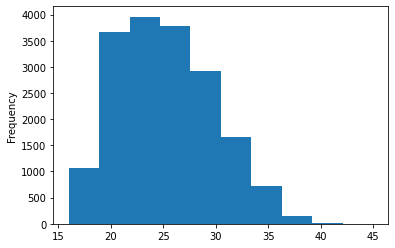

In [48]:
fifa_df['Age'].plot.hist(bins=10)

### Gráfica de Pie (Preferred Foot)

Selecciónes el conteo de valores del pie preferido (columna ```Preferred Foot```) y muestra la información mediante una gráfica de Pie:

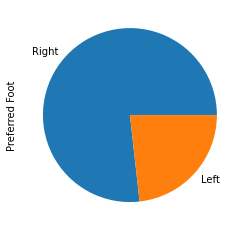

In [49]:
fifa_df['Preferred Foot'].value_counts().plot.pie()

### Gráfica de dispersión Edad vs Potential left

Ahora, utiliza una gráfica de dispersión para visualizar el comportamiento del potencial por alcanzar (```Potential left```) de acuerdo a las edades de los jugadores:

*Tip: La gráfica debe mostrar la edad en un eje y el potencial por alcanzar en el otro.*

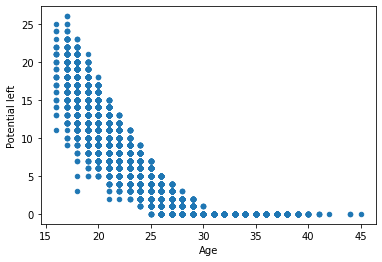

In [50]:
fifa_df.plot.scatter(x='Age', y='Potential left')

¿Qué otras variables o mezcla de variables sería interesante visualizar?

Edad y Overall para ver cuanta edad tienen los mejores y peores jugadores.



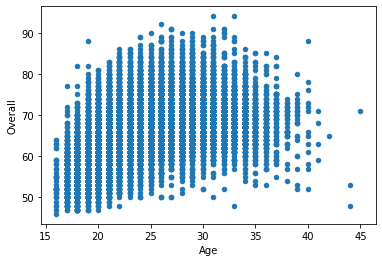

In [51]:
fifa_df.plot.scatter(x='Age', y='Overall')

# Desafío Adicional

En la práctica con Numpy, creaste un modelo para identificar imágenes de dígitos escritos a mano. 

Para este nuevo conjunto de datos, ¿podrías usar una metodología similar para encontrar la posición en el campo de un jugador solamente usando los valores de su habilidades? 

Skills: ```Shooting 	Defense 	Passing 	Physical 	Control 	Mental 	GoalKeeping```

In [60]:
import numpy as np

skills_df = fifa_df.loc[:, "Shooting":"GoalKeeping"]
y = fifa_df["Position"]

In [53]:
def class_representatives(X, y):
  representatives = X.groupby(y).mean()
  return representatives



In [54]:
representatives_df = class_representatives(skills_df,y)


In [55]:
representatives_df

,Shooting,Defense,Passing,Physical,Control,Mental,GoalKeeping
Position,,,,,,,
Center Back (CB),39.440707,57.958381,47.750285,61.099202,49.531927,51.751425,10.505701
Center Forward (CF),59.270270,35.932432,57.432432,68.445946,70.081081,62.148649,9.878378
Central Attacking Midfielder (CAM),58.210970,44.566456,63.239451,66.476793,69.940928,63.670886,10.489451
Central Defensive Midfielder (CDM),50.778846,61.333333,61.315171,65.305556,63.266026,61.259615,10.577991
Central Midfield (CM),52.965142,55.779956,62.090777,65.426289,65.816993,61.179375,10.433551
Goalkeeper (GK),15.380522,14.323293,22.441265,44.127510,25.601908,47.028112,63.721386
Left Attacking Midfielder (LAM),62.476190,40.238095,68.285714,69.904762,73.857143,70.142857,10.666667
Left Back (LB),47.332567,61.746360,60.037548,69.247510,64.360920,57.204598,10.503448
Left Center Back (LCB),42.695447,61.927786,53.284144,63.262166,53.058085,56.555730,10.599686


In [62]:
skills_df

,Shooting,Defense,Passing,Physical,Control,Mental,GoalKeeping
0,86.0,41.0,87.0,80.0,96.0,95.0,11.0
1,74.0,46.0,78.0,77.0,91.0,84.0,8.0
2,79.0,46.0,78.0,69.0,78.0,82.0,12.0
3,80.0,49.0,73.0,73.0,75.0,78.0,11.0
4,70.0,32.0,72.0,72.0,77.0,72.0,9.0
...,...,...,...,...,...,...,...
17913,36.0,51.0,52.0,71.0,63.0,43.0,11.0
17914,48.0,46.0,55.0,67.0,66.0,51.0,8.0
17915,30.0,49.0,34.0,67.0,43.0,38.0,10.0
17916,32.0,53.0,41.0,65.0,59.0,44.0,11.0


In [57]:
def euclidean_distance(X, points):
  
  best = pd.Series(data="None", index=X.index)
  best_distance = pd.Series(data=np.inf, index=X.index)
  
  for c in points.index:
    d = np.sqrt(((X - points.loc[c])**2).sum(axis=1))
    best[d<best_distance] = c
    best_distance[d<best_distance] = d[d<best_distance]

  return best 







In [61]:
y_pred = euclidean_distance(skills_df, representatives_df)
y_pred

0                      Left Forward (LF)
1                      Left Forward (LF)
2                      Left Forward (LF)
3                     Right Forward (RF)
4        Left Attacking Midfielder (LAM)
                      ...               
17913              Right Wing Back (RWB)
17914              Right Midfielder (RM)
17915                   Center Back (CB)
17916                   Center Back (CB)
17917                   Center Back (CB)
Length: 17918, dtype: object

In [63]:
(y == y_pred).mean()

0.3207389217546601